In [199]:
import os
import sys
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [200]:
def xyz2lonlat(xyz):
    atan2 = np.arctan2
    asin = np.arcsin

    norm = np.linalg.norm(xyz, axis=-1, keepdims=True)
    xyz_norm = xyz / norm
    x = xyz_norm[..., 0:1]
    y = xyz_norm[..., 1:2]
    z = xyz_norm[..., 2:]

    lon = atan2(x, z)
    lat = asin(y)
    lst = [lon, lat]

    out = np.concatenate(lst, axis=-1)
    return out

def lonlat2XY(lonlat, shape):
    X = (lonlat[..., 0:1] / (2 * np.pi) + 0.5) * (shape[1] - 1)
    Y = (lonlat[..., 1:] / (np.pi) + 0.5) * (shape[0] - 1)
    lst = [X, Y]
    out = np.concatenate(lst, axis=-1)

    return out 

class Equirectangular:
    def __init__(self, img_name):
        self._img = cv2.imread(img_name, cv2.IMREAD_COLOR)
        [self._height, self._width, _] = self._img.shape
        #cp = self._img.copy()  
        #w = self._width
        #self._img[:, :w/8, :] = cp[:, 7*w/8:, :]
        #self._img[:, w/8:, :] = cp[:, :7*w/8, :]
    

    def GetPerspective(self, FOV, THETA, PHI, height, width):
        #
        # THETA is left/right angle, PHI is up/down angle, both in degree
        #

        f = 0.5 * width * 1 / np.tan(0.5 * FOV / 180.0 * np.pi)
        cx = (width - 1) / 2.0
        cy = (height - 1) / 2.0
        K = np.array([
                [f, 0, cx],
                [0, f, cy],
                [0, 0,  1],
            ], np.float32)
        K_inv = np.linalg.inv(K)
        
        x = np.arange(width)
        y = np.arange(height)
        x, y = np.meshgrid(x, y)
        z = np.ones_like(x)
        xyz = np.concatenate([x[..., None], y[..., None], z[..., None]], axis=-1)
        xyz = xyz @ K_inv.T

        y_axis = np.array([0.0, 1.0, 0.0], np.float32)
        x_axis = np.array([1.0, 0.0, 0.0], np.float32)
        R1, _ = cv2.Rodrigues(y_axis * np.radians(THETA))
        R2, _ = cv2.Rodrigues(np.dot(R1, x_axis) * np.radians(PHI))
        R = R2 @ R1
        xyz = xyz @ R.T
        lonlat = xyz2lonlat(xyz) 
        XY = lonlat2XY(lonlat, shape=self._img.shape).astype(np.float32)
        persp = cv2.remap(self._img, XY[..., 0], XY[..., 1], cv2.INTER_CUBIC, borderMode=cv2.BORDER_WRAP)

        return persp
    
    def Project2Perspective(self, xyz, FOV, THETA, PHI, height, width):
        #
        # THETA is left/right angle, PHI is up/down angle, both in degree
        #

        f = 0.5 * width * 1 / np.tan(0.5 * FOV / 180.0 * np.pi)
        cx = (width - 1) / 2.0
        cy = (height - 1) / 2.0
        K = np.array([
                [f, 0, cx],
                [0, f, cy],
                [0, 0,  1],
            ], np.float32)
        # K_inv = np.linalg.inv(K)
        
        # xyz = xyz @ K.T

        y_axis = np.array([0.0, 1.0, 0.0], np.float32)
        x_axis = np.array([1.0, 0.0, 0.0], np.float32)
        R1, _ = cv2.Rodrigues(y_axis * np.radians(THETA))
        R2, _ = cv2.Rodrigues(np.dot(R1, x_axis) * np.radians(PHI))
        R = R2 @ R1
        xyz = xyz @ R.T
        lonlat = xyz2lonlat(xyz) 
        XY = lonlat2XY(lonlat, shape=self._img.shape).astype(np.float32)

        return XY

## 1. Load Data and Show Depth

(-0.5, 1023.5, 511.5, -0.5)

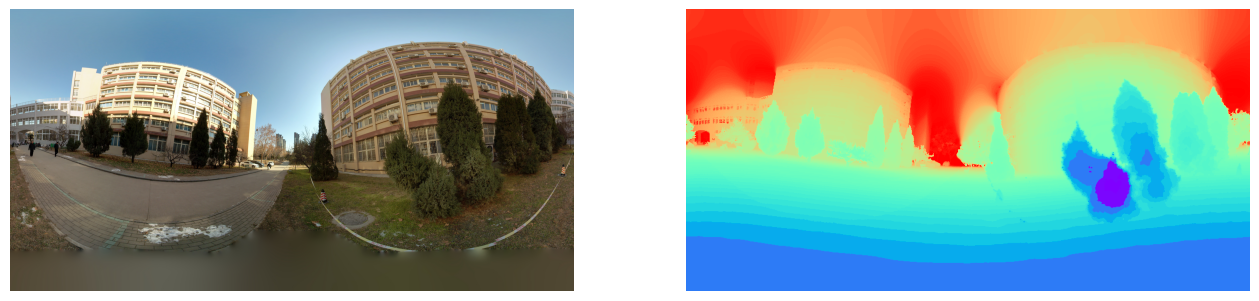

In [211]:
dir_path = "../data/taiyuan_post/2024-01-25_04.25.47"
image_num = len(os.listdir(os.path.join(dir_path, "pano")))
image_idx = np.random.randint(0, image_num)
rgb_img_path = os.path.join(dir_path, "pano", f"{image_idx:05d}-pano.jpg")
depth_img_path = os.path.join(dir_path, "pano_depth", f"{image_idx:05d}-pano_depth.png")
pcd_path = os.path.join(dir_path, "pointcloud.ply")
rgb_image = cv2.imread(rgb_img_path)
rgb_image = cv2.cvtColor(rgb_image, cv2.COLOR_BGR2RGB)
depth_img = cv2.imread(depth_img_path, cv2.IMREAD_UNCHANGED)
depth_img = cv2.equalizeHist(depth_img[..., 1])

plt.style.use('seaborn-v0_8-white')
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.imshow(rgb_image)
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(depth_img, cmap='rainbow')
plt.axis('off')

## 2. Transform to Perspective View

In [212]:
# image_idx = np.random.randint(0, image_num)
rgb_img_path = os.path.join(dir_path, "pano", f"{image_idx:05d}-pano.jpg")
equ = Equirectangular(rgb_img_path)

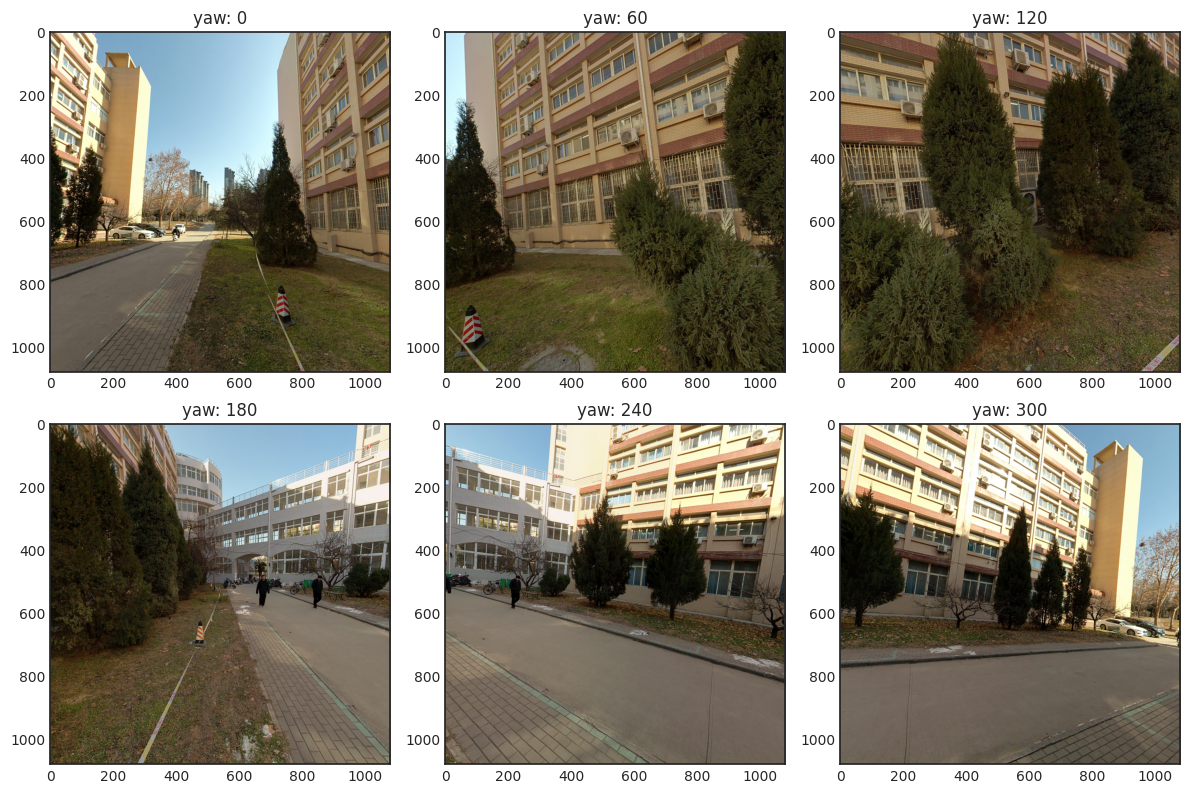

In [213]:
plt.style.use('seaborn-v0_8-white')
plt.figure(figsize=(12, 8))
for yaw in range(0, 360, 60):
    # Specify parameters(FOV, theta, phi, height, width)
    # first yaw then pitch
    persp_img = cv2.cvtColor(equ.GetPerspective(90, yaw, 0, 1080, 1080), cv2.COLOR_BGR2RGB)
    plt.subplot(2, 3, yaw // 60 + 1)
    plt.imshow(persp_img)
    plt.title(f"yaw: {yaw}")
    plt.tight_layout()

## 3. Porject Points to Perspective View

In [214]:
import sys
sys.path.append("/home/yang_liu/python_workspace/gaussian-splatting-lightning")

import json
import torch
import pandas as pd
from plyfile import PlyData
from internal.utils.gaussian_projection import build_rotation_matrix

In [215]:
ds_interval = 50
plydata = PlyData.read(pcd_path)
data = plydata.elements[0].data[::ds_interval]
property_names = data[0].dtype.names
data = pd.DataFrame(data)
data_np = np.zeros(data.shape, dtype=float)
for i, name in enumerate(property_names):
    data_np[:, i] = data[name]
xyz = data_np[:, :3]
rgb = data_np[:, 3:6] / 255.0

In [216]:
image_idx = np.random.randint(0, image_num)
rgb_img_path = os.path.join(dir_path, "pano", f"{image_idx:05d}-pano.jpg")
rgb_image = cv2.imread(rgb_img_path)
rgb_image = cv2.cvtColor(rgb_image, cv2.COLOR_BGR2RGB)

equ = Equirectangular(rgb_img_path)

In [217]:
info_path = os.path.join(dir_path, "info", f"{image_idx:05d}-info.json")
with open(info_path, "r") as f:
    info = json.loads(f.read())

cam_idx = 1
cam = info[f"cam{cam_idx}"]
cam_p = cam['position']
cam_q = cam['quaternion']
c2w = np.eye(4)
c2w[:3, :3] = np.array(build_rotation_matrix(torch.tensor(cam_q)[None, :]))[0]
c2w[:3, 3] = np.array(cam_p)

c2w[:, 1] *= -1  # cam 1, 2, 3
c2w = c2w[:, [1, 0, 2, 3]]
w2c = np.linalg.inv(c2w)

print("image_idx: \n", image_idx)
print("c2w: \n", c2w)
print("Extrinsics: \n", w2c)

image_idx: 
 48
c2w: 
 [[ -0.76189685   0.19501978   0.61764097 -25.21242397]
 [ -0.6469413   -0.27522814  -0.71113741  23.5902511 ]
 [  0.03130633  -0.94139087   0.33586186   0.39955364]
 [ -0.           0.           0.           1.        ]]
Extrinsics: 
 [[-7.61896927e-01 -6.46941297e-01  3.13063153e-02 -3.96026924e+00]
 [ 1.95019816e-01 -2.75228171e-01 -9.41390836e-01  1.17857601e+01]
 [ 6.17641037e-01 -7.11137405e-01  3.35861815e-01  3.22139428e+01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


In [218]:
xyz_h = np.concatenate([xyz, np.ones((xyz.shape[0], 1))], axis=-1)
xyz_cam = np.dot(xyz_h, w2c.T)
xyz_cam = xyz_cam[:, :3]
xyz_proj = xyz_cam
# xyz_proj = xyz_cam / xyz_cam[:, [2]]

In [219]:
yaw = 0
persp_img = cv2.cvtColor(equ.GetPerspective(90, yaw, 0, 1080, 1080), cv2.COLOR_BGR2RGB)
XY = equ.Project2Perspective(xyz_proj, 90, yaw, 0, 1080, 1080)

# valid_pcd = np.all(xyz >= 0, axis=-1) & (xyz[:, 0] < 1080) & (xyz[:, 1] < 1080)
# valid_xyz = XY[valid_pcd]
# valid_rgb = rgb[valid_pcd]

valid_xyz = XY
valid_rgb = rgb
sort_idx = np.argsort(-np.linalg.norm(valid_xyz, axis=-1))
valid_xyz = valid_xyz[sort_idx]
valid_rgb = valid_rgb[sort_idx]

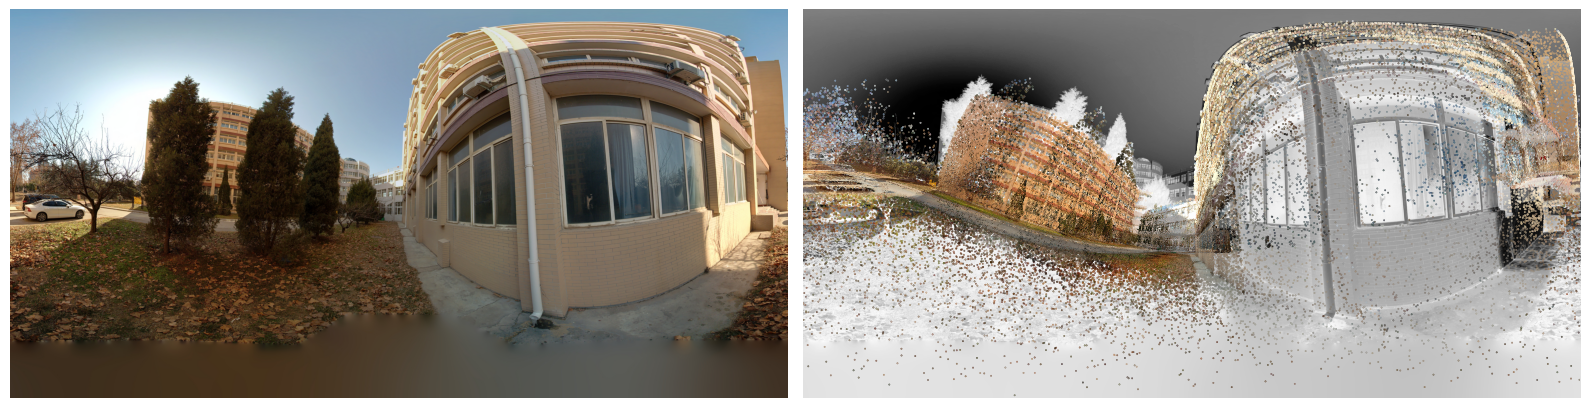

In [220]:
plt.style.use('seaborn-v0_8-white')
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.imshow(rgb_image)
plt.axis('off')
plt.tight_layout()

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(rgb_image, cv2.COLOR_RGB2GRAY))
plt.scatter(valid_xyz[::10, 0], valid_xyz[::10, 1], s=0.1, c=valid_rgb[::10])
plt.axis('off')
plt.tight_layout()